In [ ]:
# 📊 Phân Tích Dữ Liệu Khám Phá (EDA) và Định Nghĩa Churn

## Mục tiêu
- Phân tích dữ liệu khách hàng và giao dịch
- Xác định ngưỡng thời gian không hoạt động (inactivity window) hợp lý
- Định nghĩa churn dựa trên hành vi giao dịch
- Chuẩn bị dữ liệu cho các phân tích tiếp theo (RFM, CLV)

---

In [1]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Cài đặt style cho biểu đồ
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Định nghĩa ngày phân tích (giả định ngày hiện tại)
ANALYSIS_DATE = pd.Timestamp('2025-12-31')
print(f"📅 Ngày phân tích: {ANALYSIS_DATE.strftime('%Y-%m-%d')}")

📅 Ngày phân tích: 2025-12-31


## 1. Đọc và Khám Phá Dữ Liệu

### 1.1 Đọc dữ liệu từ file CSV

In [2]:
# Đọc dữ liệu
customers = pd.read_csv('../customers.csv')
transactions = pd.read_csv('../transactions.csv')

# Chuyển đổi kiểu dữ liệu
customers['signup_date'] = pd.to_datetime(customers['signup_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

print("=" * 60)
print("📋 THÔNG TIN DỮ LIỆU CUSTOMERS")
print("=" * 60)
print(f"Số lượng khách hàng: {len(customers):,}")
print(f"\nCác cột: {list(customers.columns)}")
print(f"\n🔍 5 dòng đầu tiên:")
display(customers.head())

print("\n" + "=" * 60)
print("📋 THÔNG TIN DỮ LIỆU TRANSACTIONS")
print("=" * 60)
print(f"Số lượng giao dịch: {len(transactions):,}")
print(f"\nCác cột: {list(transactions.columns)}")
print(f"\n🔍 5 dòng đầu tiên:")
display(transactions.head())

📋 THÔNG TIN DỮ LIỆU CUSTOMERS
Số lượng khách hàng: 3,000

Các cột: ['customer_id', 'signup_date', 'true_lifetime_days']

🔍 5 dòng đầu tiên:


,customer_id,signup_date,true_lifetime_days
0,C00000,2025-08-22,204
1,C00001,2025-03-07,365
2,C00002,2025-08-18,48
3,C00003,2025-09-22,84
4,C00004,2025-05-28,113



📋 THÔNG TIN DỮ LIỆU TRANSACTIONS
Số lượng giao dịch: 46,704

Các cột: ['customer_id', 'transaction_date', 'amount']

🔍 5 dòng đầu tiên:


,customer_id,transaction_date,amount
0,C00000,2025-09-10,195.78
1,C00000,2025-09-12,50.87
2,C00000,2025-10-01,133.25
3,C00000,2025-10-16,37.44
4,C00000,2025-10-18,101.95


### 1.2 Thống kê mô tả dữ liệu

In [3]:
# Thống kê mô tả customers
print("=" * 60)
print("📊 THỐNG KÊ MÔ TẢ - CUSTOMERS")
print("=" * 60)
print(f"\n⏰ Khoảng thời gian signup: {customers['signup_date'].min()} đến {customers['signup_date'].max()}")
print(f"\n📈 Thống kê true_lifetime_days:")
display(customers['true_lifetime_days'].describe())

# Kiểm tra missing values
print("\n🔍 Missing Values - Customers:")
print(customers.isnull().sum())

print("\n" + "=" * 60)
print("📊 THỐNG KÊ MÔ TẢ - TRANSACTIONS")
print("=" * 60)
print(f"\n⏰ Khoảng thời gian giao dịch: {transactions['transaction_date'].min()} đến {transactions['transaction_date'].max()}")
print(f"\n💰 Thống kê giá trị giao dịch (amount):")
display(transactions['amount'].describe())

# Kiểm tra missing values
print("\n🔍 Missing Values - Transactions:")
print(transactions.isnull().sum())

📊 THỐNG KÊ MÔ TẢ - CUSTOMERS

⏰ Khoảng thời gian signup: 2025-01-02 00:00:00 đến 2025-12-02 00:00:00

📈 Thống kê true_lifetime_days:


count    3000.000000
mean      156.771000
std        97.302387
min        30.000000
25%        78.000000
50%       137.000000
75%       220.000000
max       365.000000
Name: true_lifetime_days, dtype: float64


🔍 Missing Values - Customers:
customer_id           0
signup_date           0
true_lifetime_days    0
dtype: int64

📊 THỐNG KÊ MÔ TẢ - TRANSACTIONS

⏰ Khoảng thời gian giao dịch: 2025-01-03 00:00:00 đến 2025-12-31 00:00:00

💰 Thống kê giá trị giao dịch (amount):


count    46704.000000
mean        58.263586
std         57.662026
min          0.060000
25%         20.100000
50%         40.780000
75%         76.542500
max        887.830000
Name: amount, dtype: float64


🔍 Missing Values - Transactions:
customer_id         0
transaction_date    0
amount              0
dtype: int64


### 📝 Nhận xét bước 1:
- **Customers**: 3,000 khách hàng, signup từ 02/01/2025 đến 02/12/2025
- **Transactions**: 46,704 giao dịch, từ 03/01/2025 đến 31/12/2025
- **True lifetime days**: Trung bình ~157 ngày, min 30 ngày, max 365 ngày
- **Giá trị giao dịch**: Trung bình ~58$, phạm vi 0.06$ - 887.83$
- **Không có missing values** trong cả hai tập dữ liệu

---

## 2. Phân Tích Hành Vi Giao Dịch

### 2.1 Tính toán các chỉ số RFM cơ bản

In [4]:
# Tính toán RFM cho mỗi khách hàng
rfm = transactions.groupby('customer_id').agg({
    'transaction_date': ['max', 'count'],  # Last transaction date, Frequency
    'amount': ['sum', 'mean']               # Total & Average monetary value
}).reset_index()

# Đổi tên cột
rfm.columns = ['customer_id', 'last_transaction_date', 'frequency', 'total_amount', 'avg_amount']

# Tính Recency (số ngày từ giao dịch cuối đến ngày phân tích)
rfm['recency'] = (ANALYSIS_DATE - rfm['last_transaction_date']).dt.days

# Merge với customers để lấy thêm thông tin
rfm = rfm.merge(customers, on='customer_id', how='left')

# Tính thời gian từ signup đến giao dịch cuối
rfm['days_active'] = (rfm['last_transaction_date'] - rfm['signup_date']).dt.days

print("=" * 60)
print("📊 BẢNG RFM - 10 KHÁCH HÀNG ĐẦU TIÊN")
print("=" * 60)
display(rfm.head(10))

print("\n" + "=" * 60)
print("📈 THỐNG KÊ RFM")
print("=" * 60)
display(rfm[['recency', 'frequency', 'total_amount', 'avg_amount', 'days_active']].describe())

📊 BẢNG RFM - 10 KHÁCH HÀNG ĐẦU TIÊN


,customer_id,last_transaction_date,frequency,total_amount,avg_amount,recency,signup_date,true_lifetime_days,days_active
0,C00000,2025-12-31,12,1222.85,101.904167,0,2025-08-22,204,131
1,C00001,2025-12-20,19,1228.46,64.655789,11,2025-03-07,365,288
2,C00002,2025-09-26,11,910.64,82.785455,96,2025-08-18,48,39
3,C00003,2025-11-18,4,114.71,28.677500,43,2025-09-22,84,57
4,C00004,2025-09-14,19,2018.94,106.260000,108,2025-05-28,113,109
5,C00005,2025-12-29,8,209.12,26.140000,2,2025-11-12,120,47
6,C00006,2025-11-25,3,85.95,28.650000,36,2025-08-22,117,95
7,C00007,2025-09-30,5,584.63,116.926000,92,2025-08-03,321,58
8,C00008,2025-10-31,14,768.16,54.868571,61,2025-05-02,209,182
9,C00009,2025-06-19,18,1697.28,94.293333,195,2025-01-06,172,164



📈 THỐNG KÊ RFM


,recency,frequency,total_amount,avg_amount,days_active
count,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000
mean,87.207123,16.149378,940.920654,59.074524,108.167704
std,90.953968,17.138352,1206.226060,39.140065,72.047631
min,0.000000,1.000000,1.700000,0.690000,1.000000
25%,6.000000,5.000000,206.612500,30.862632,49.000000
50%,54.000000,11.000000,538.440000,51.545982,94.000000
75%,154.000000,21.000000,1212.687500,76.690114,154.000000
max,353.000000,155.000000,13966.820000,399.520000,355.000000


### 2.2 Trực quan hóa phân phối RFM

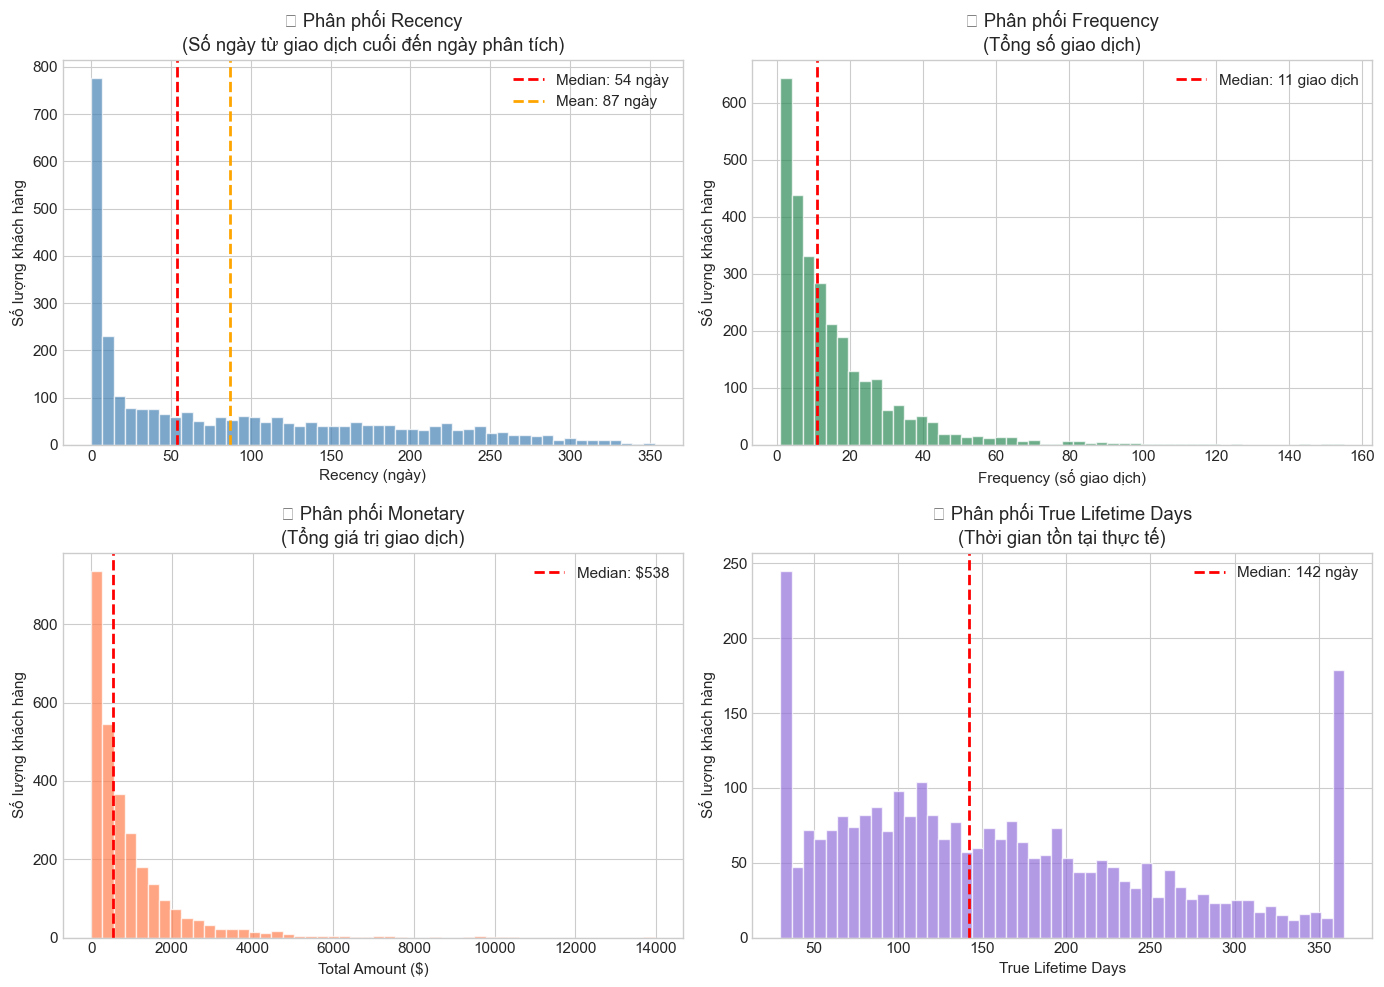

In [5]:
# Trực quan hóa phân phối RFM
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Phân phối Recency
ax1 = axes[0, 0]
ax1.hist(rfm['recency'], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(rfm['recency'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {rfm["recency"].median():.0f} ngày')
ax1.axvline(rfm['recency'].mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {rfm["recency"].mean():.0f} ngày')
ax1.set_xlabel('Recency (ngày)')
ax1.set_ylabel('Số lượng khách hàng')
ax1.set_title('📊 Phân phối Recency\n(Số ngày từ giao dịch cuối đến ngày phân tích)')
ax1.legend()

# 2. Phân phối Frequency
ax2 = axes[0, 1]
ax2.hist(rfm['frequency'], bins=50, color='seagreen', edgecolor='white', alpha=0.7)
ax2.axvline(rfm['frequency'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {rfm["frequency"].median():.0f} giao dịch')
ax2.set_xlabel('Frequency (số giao dịch)')
ax2.set_ylabel('Số lượng khách hàng')
ax2.set_title('📊 Phân phối Frequency\n(Tổng số giao dịch)')
ax2.legend()

# 3. Phân phối Total Amount
ax3 = axes[1, 0]
ax3.hist(rfm['total_amount'], bins=50, color='coral', edgecolor='white', alpha=0.7)
ax3.axvline(rfm['total_amount'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: ${rfm["total_amount"].median():.0f}')
ax3.set_xlabel('Total Amount ($)')
ax3.set_ylabel('Số lượng khách hàng')
ax3.set_title('📊 Phân phối Monetary\n(Tổng giá trị giao dịch)')
ax3.legend()

# 4. Phân phối True Lifetime Days
ax4 = axes[1, 1]
ax4.hist(rfm['true_lifetime_days'], bins=50, color='mediumpurple', edgecolor='white', alpha=0.7)
ax4.axvline(rfm['true_lifetime_days'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {rfm["true_lifetime_days"].median():.0f} ngày')
ax4.set_xlabel('True Lifetime Days')
ax4.set_ylabel('Số lượng khách hàng')
ax4.set_title('📊 Phân phối True Lifetime Days\n(Thời gian tồn tại thực tế)')
ax4.legend()

plt.tight_layout()
plt.show()

### 📝 Nhận xét RFM:
- **Recency**: Phân phối lệch phải mạnh, nhiều khách hàng có giao dịch gần đây (0-50 ngày). Median 54 ngày, Mean 87 ngày
- **Frequency**: Phân phối lệch phải, đa số có 5-20 giao dịch, median 11 giao dịch
- **Monetary**: Phân phối lệch phải mạnh, median $538, một số ít khách hàng có giá trị rất cao
- **True Lifetime Days**: Phân bố đa dạng, có đỉnh ở 30 ngày và 365 ngày (có thể là churned sớm và retained lâu dài)

---

## 3. Phân Tích Khoảng Thời Gian Giữa Các Giao Dịch

Đây là bước **quan trọng nhất** để xác định ngưỡng churn hợp lý

### 3.1 Tính toán inter-transaction time

In [6]:
# Sắp xếp giao dịch theo khách hàng và ngày
transactions_sorted = transactions.sort_values(['customer_id', 'transaction_date'])

# Tính thời gian giữa các giao dịch liên tiếp của mỗi khách hàng
transactions_sorted['prev_transaction_date'] = transactions_sorted.groupby('customer_id')['transaction_date'].shift(1)
transactions_sorted['days_between'] = (transactions_sorted['transaction_date'] - transactions_sorted['prev_transaction_date']).dt.days

# Loại bỏ NaN (giao dịch đầu tiên của mỗi khách hàng)
inter_transaction_time = transactions_sorted['days_between'].dropna()

print("=" * 60)
print("📊 THỐNG KÊ THỜI GIAN GIỮA CÁC GIAO DỊCH")
print("=" * 60)
print(f"\nSố lượng khoảng thời gian: {len(inter_transaction_time):,}")
print(f"\n📈 Thống kê mô tả:")
display(inter_transaction_time.describe())

# Các percentile quan trọng
print("\n📊 Các percentile quan trọng:")
percentiles = [50, 75, 80, 85, 90, 95, 99]
for p in percentiles:
    value = inter_transaction_time.quantile(p/100)
    print(f"  P{p}: {value:.1f} ngày")

📊 THỐNG KÊ THỜI GIAN GIỮA CÁC GIAO DỊCH

Số lượng khoảng thời gian: 43,812

📈 Thống kê mô tả:


count    43812.000000
mean         6.307245
std          9.344010
min          0.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        167.000000
Name: days_between, dtype: float64


📊 Các percentile quan trọng:
  P50: 3.0 ngày
  P75: 8.0 ngày
  P80: 9.0 ngày
  P85: 12.0 ngày
  P90: 16.0 ngày
  P95: 23.0 ngày
  P99: 44.0 ngày


### 3.2 Trực quan hóa phân phối inter-transaction time

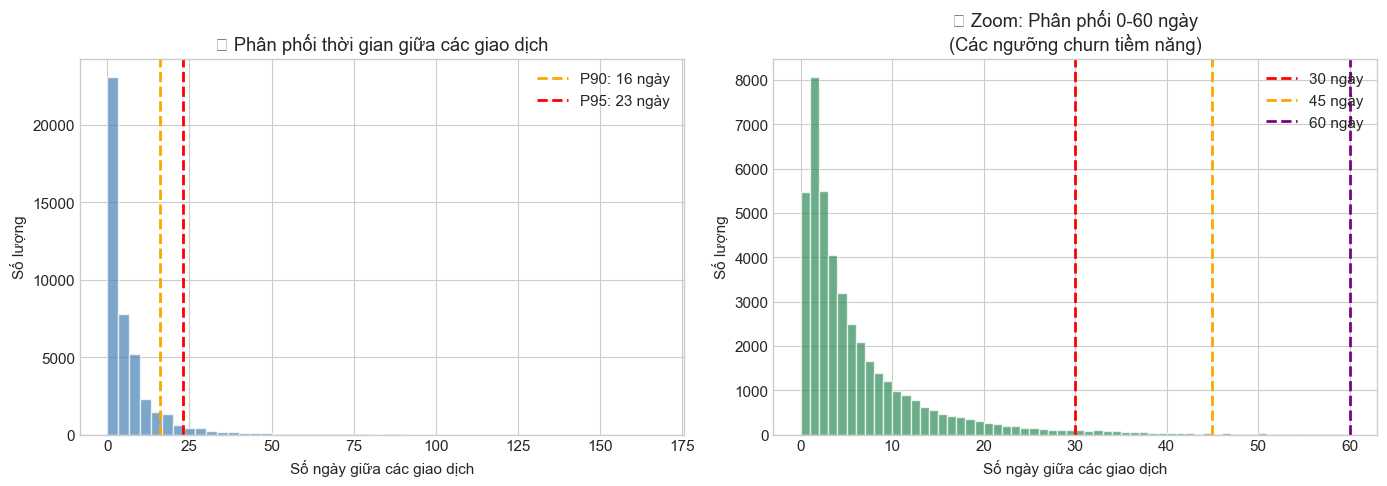


📊 Phần trăm giao dịch theo ngưỡng thời gian:
  ≤ 30 ngày: 97.30%
  ≤ 45 ngày: 99.07%
  ≤ 60 ngày: 99.60%
  ≤ 90 ngày: 99.91%


In [7]:
# Trực quan hóa phân phối inter-transaction time
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Histogram với tất cả dữ liệu
ax1 = axes[0]
ax1.hist(inter_transaction_time, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(inter_transaction_time.quantile(0.90), color='orange', linestyle='--', linewidth=2, label=f'P90: {inter_transaction_time.quantile(0.90):.0f} ngày')
ax1.axvline(inter_transaction_time.quantile(0.95), color='red', linestyle='--', linewidth=2, label=f'P95: {inter_transaction_time.quantile(0.95):.0f} ngày')
ax1.set_xlabel('Số ngày giữa các giao dịch')
ax1.set_ylabel('Số lượng')
ax1.set_title('📊 Phân phối thời gian giữa các giao dịch')
ax1.legend()

# 2. Zoom vào phần 0-60 ngày
ax2 = axes[1]
inter_time_filtered = inter_transaction_time[inter_transaction_time <= 60]
ax2.hist(inter_time_filtered, bins=60, color='seagreen', edgecolor='white', alpha=0.7)
ax2.axvline(30, color='red', linestyle='--', linewidth=2, label='30 ngày')
ax2.axvline(45, color='orange', linestyle='--', linewidth=2, label='45 ngày')
ax2.axvline(60, color='purple', linestyle='--', linewidth=2, label='60 ngày')
ax2.set_xlabel('Số ngày giữa các giao dịch')
ax2.set_ylabel('Số lượng')
ax2.set_title('📊 Zoom: Phân phối 0-60 ngày\n(Các ngưỡng churn tiềm năng)')
ax2.legend()

plt.tight_layout()
plt.show()

# Tính % giao dịch trong các ngưỡng
print("\n📊 Phần trăm giao dịch theo ngưỡng thời gian:")
thresholds = [30, 45, 60, 90]
for t in thresholds:
    pct = (inter_transaction_time <= t).sum() / len(inter_transaction_time) * 100
    print(f"  ≤ {t} ngày: {pct:.2f}%")

### 📝 Insight quan trọng về Inter-Transaction Time:
- **97.3%** giao dịch xảy ra trong vòng **30 ngày** sau giao dịch trước
- **99.07%** giao dịch xảy ra trong vòng **45 ngày**
- **99.6%** giao dịch xảy ra trong vòng **60 ngày**
- Median chỉ **3 ngày**, P90 là **16 ngày**, P95 là **23 ngày**

**➡️ Đề xuất**: Nếu khách hàng không có giao dịch trong **30-45 ngày** có thể coi là có nguy cơ churn cao

---

## 4. Phân Tích Mối Quan Hệ Recency và True Lifetime

### 4.1 Tương quan giữa Recency và True Lifetime Days

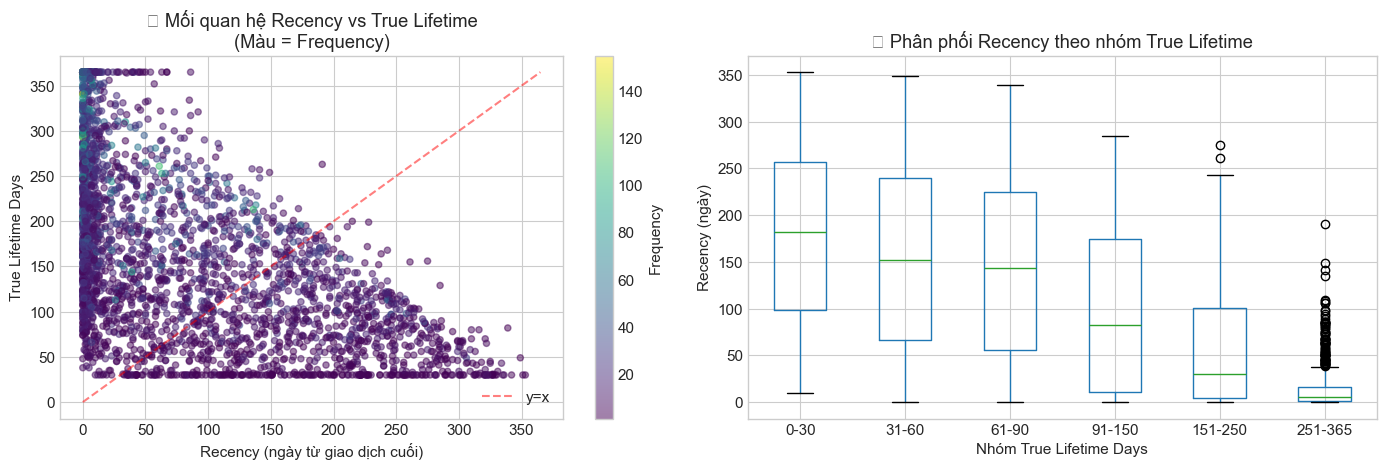


📈 Hệ số tương quan Pearson (Recency vs True Lifetime): -0.559


In [8]:
# Phân tích mối quan hệ giữa Recency và True Lifetime Days
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Scatter plot
ax1 = axes[0]
scatter = ax1.scatter(rfm['recency'], rfm['true_lifetime_days'], 
                      c=rfm['frequency'], cmap='viridis', alpha=0.5, s=20)
ax1.set_xlabel('Recency (ngày từ giao dịch cuối)')
ax1.set_ylabel('True Lifetime Days')
ax1.set_title('📊 Mối quan hệ Recency vs True Lifetime\n(Màu = Frequency)')
plt.colorbar(scatter, ax=ax1, label='Frequency')

# Thêm đường y=x để tham khảo
max_val = max(rfm['recency'].max(), rfm['true_lifetime_days'].max())
ax1.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='y=x')
ax1.legend()

# 2. Boxplot của Recency theo nhóm True Lifetime
ax2 = axes[1]
rfm['lifetime_group'] = pd.cut(rfm['true_lifetime_days'], 
                                bins=[0, 30, 60, 90, 150, 250, 365],
                                labels=['0-30', '31-60', '61-90', '91-150', '151-250', '251-365'])
rfm.boxplot(column='recency', by='lifetime_group', ax=ax2)
ax2.set_xlabel('Nhóm True Lifetime Days')
ax2.set_ylabel('Recency (ngày)')
ax2.set_title('📊 Phân phối Recency theo nhóm True Lifetime')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Tính correlation
correlation = rfm['recency'].corr(rfm['true_lifetime_days'])
print(f"\n📈 Hệ số tương quan Pearson (Recency vs True Lifetime): {correlation:.3f}")

### 4.2 Phân tích sâu hơn về các nhóm lifetime

In [9]:
# Phân tích chi tiết theo nhóm lifetime
print("=" * 60)
print("📊 PHÂN TÍCH CHI TIẾT THEO NHÓM TRUE LIFETIME DAYS")
print("=" * 60)

# Thống kê theo nhóm
lifetime_stats = rfm.groupby('lifetime_group', observed=True).agg({
    'customer_id': 'count',
    'recency': ['mean', 'median'],
    'frequency': 'mean',
    'total_amount': 'mean'
}).round(2)

lifetime_stats.columns = ['Số KH', 'Recency TB', 'Recency Median', 'Frequency TB', 'Amount TB']
display(lifetime_stats)

# Tính tỷ lệ khách hàng có recency cao (potential churn) trong mỗi nhóm
print("\n📊 Tỷ lệ khách hàng có Recency > 30 ngày theo nhóm lifetime:")
for group in rfm['lifetime_group'].dropna().unique():
    group_data = rfm[rfm['lifetime_group'] == group]
    high_recency_pct = (group_data['recency'] > 30).sum() / len(group_data) * 100
    print(f"  {group}: {high_recency_pct:.1f}%")

📊 PHÂN TÍCH CHI TIẾT THEO NHÓM TRUE LIFETIME DAYS


,Số KH,Recency TB,Recency Median,Frequency TB,Amount TB
lifetime_group,,,,,
0-30,190,179.16,181.5,3.67,209.07
31-60,274,156.66,152.0,5.28,358.02
61-90,362,142.86,143.5,7.71,442.00
91-150,696,97.83,82.0,12.02,687.69
151-250,819,57.10,30.0,19.54,1167.86
251-365,551,15.73,5.0,31.59,1793.47



📊 Tỷ lệ khách hàng có Recency > 30 ngày theo nhóm lifetime:
  151-250: 49.8%
  251-365: 16.7%
  31-60: 87.2%
  61-90: 82.0%
  91-150: 66.5%
  0-30: 96.8%


### 📝 Nhận xét quan trọng:

**1. Tương quan âm mạnh (-0.559) giữa Recency và True Lifetime:**
- Khách hàng có true lifetime dài hơn → có xu hướng recency thấp hơn (giao dịch gần đây hơn)
- Khách hàng có true lifetime ngắn → recency cao (đã lâu không giao dịch)

**2. Pattern rõ ràng theo nhóm lifetime:**
- **Nhóm 0-30 ngày**: 96.8% có recency > 30 ngày → Đây là nhóm churned sớm
- **Nhóm 251-365 ngày**: Chỉ 16.7% có recency > 30 ngày → Đây là khách hàng trung thành
- Recency median giảm dần từ 181.5 ngày (nhóm 0-30) xuống 5 ngày (nhóm 251-365)

**3. Frequency và Amount tỷ lệ thuận với Lifetime:**
- Khách hàng trung thành (251-365 ngày) có trung bình 31.6 giao dịch, tổng $1,793
- Khách hàng churned sớm (0-30 ngày) chỉ có 3.7 giao dịch, tổng $209

---

## 5. Xác Định Ngưỡng Churn Tối Ưu

### 5.1 So sánh các ngưỡng churn tiềm năng

📊 SO SÁNH TỶ LỆ CHURN VỚI CÁC NGƯỠNG KHÁC NHAU


,Ngưỡng (ngày),Số KH Churned,Số KH Active,Tỷ lệ Churn (%)
0,30,1683,1209,58.20
1,45,1520,1372,52.56
2,60,1398,1494,48.34
3,90,1161,1731,40.15


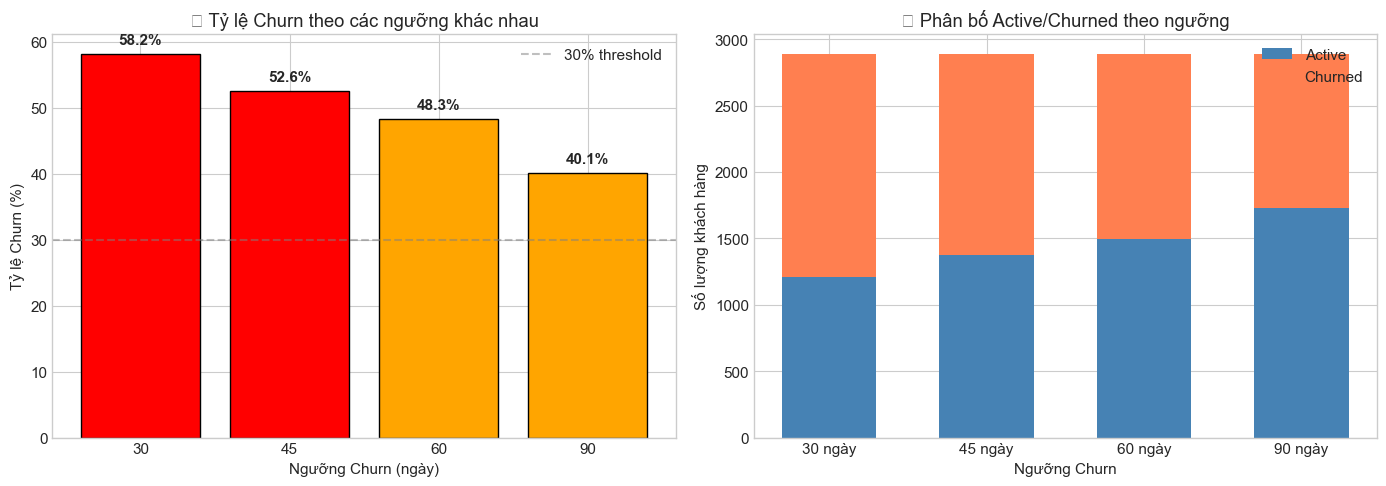

In [10]:
# So sánh tỷ lệ churn với các ngưỡng khác nhau
print("=" * 70)
print("📊 SO SÁNH TỶ LỆ CHURN VỚI CÁC NGƯỠNG KHÁC NHAU")
print("=" * 70)

thresholds = [30, 45, 60, 90]
results = []

for threshold in thresholds:
    # Định nghĩa churn: Recency > threshold
    churn = (rfm['recency'] > threshold).astype(int)
    churn_rate = churn.mean() * 100
    
    # Số khách hàng churned
    n_churned = churn.sum()
    n_active = len(churn) - n_churned
    
    results.append({
        'Ngưỡng (ngày)': threshold,
        'Số KH Churned': n_churned,
        'Số KH Active': n_active,
        'Tỷ lệ Churn (%)': round(churn_rate, 2)
    })

results_df = pd.DataFrame(results)
display(results_df)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Bar chart tỷ lệ churn theo ngưỡng
ax1 = axes[0]
colors = ['green' if r < 30 else 'orange' if r < 50 else 'red' for r in results_df['Tỷ lệ Churn (%)']]
bars = ax1.bar(results_df['Ngưỡng (ngày)'].astype(str), results_df['Tỷ lệ Churn (%)'], color=colors, edgecolor='black')
ax1.set_xlabel('Ngưỡng Churn (ngày)')
ax1.set_ylabel('Tỷ lệ Churn (%)')
ax1.set_title('📊 Tỷ lệ Churn theo các ngưỡng khác nhau')
ax1.axhline(y=30, color='gray', linestyle='--', alpha=0.5, label='30% threshold')
ax1.legend()

# Thêm label trên bar
for bar, val in zip(bars, results_df['Tỷ lệ Churn (%)']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%', 
             ha='center', va='bottom', fontweight='bold')

# 2. Stacked bar chart số lượng khách hàng
ax2 = axes[1]
x = range(len(thresholds))
width = 0.6
ax2.bar(x, results_df['Số KH Active'], width, label='Active', color='steelblue')
ax2.bar(x, results_df['Số KH Churned'], width, bottom=results_df['Số KH Active'], label='Churned', color='coral')
ax2.set_xticks(x)
ax2.set_xticklabels([f'{t} ngày' for t in thresholds])
ax2.set_xlabel('Ngưỡng Churn')
ax2.set_ylabel('Số lượng khách hàng')
ax2.set_title('📊 Phân bố Active/Churned theo ngưỡng')
ax2.legend()

plt.tight_layout()
plt.show()

### 5.2 Kiểm tra tính chính xác của ngưỡng với True Lifetime

In [11]:
# Kiểm tra tính chính xác của ngưỡng churn so với true lifetime
# Giả định: Khách hàng với true_lifetime_days < 120 ngày có thể coi là "churned sớm"

# Tính ngày kết thúc thực tế của khách hàng
rfm['expected_end_date'] = rfm['signup_date'] + pd.to_timedelta(rfm['true_lifetime_days'], unit='D')

# Khách hàng "thực sự churned" nếu expected_end_date < ANALYSIS_DATE
rfm['is_truly_churned'] = (rfm['expected_end_date'] < ANALYSIS_DATE).astype(int)

print("=" * 70)
print("📊 KIỂM TRA TÍNH CHÍNH XÁC CỦA ĐỊNH NGHĨA CHURN")
print("=" * 70)

# So sánh định nghĩa churn (dựa trên recency) với true churn status
print("\n🎯 Confusion Matrix cho các ngưỡng khác nhau:")
print("(So sánh Churn dựa trên Recency vs True Churn Status)")

for threshold in [30, 45, 60, 90]:
    rfm[f'predicted_churn_{threshold}'] = (rfm['recency'] > threshold).astype(int)
    
    # Confusion matrix
    tp = ((rfm[f'predicted_churn_{threshold}'] == 1) & (rfm['is_truly_churned'] == 1)).sum()
    tn = ((rfm[f'predicted_churn_{threshold}'] == 0) & (rfm['is_truly_churned'] == 0)).sum()
    fp = ((rfm[f'predicted_churn_{threshold}'] == 1) & (rfm['is_truly_churned'] == 0)).sum()
    fn = ((rfm[f'predicted_churn_{threshold}'] == 0) & (rfm['is_truly_churned'] == 1)).sum()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn) * 100
    precision = tp / (tp + fp) * 100 if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) * 100 if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n📌 Ngưỡng {threshold} ngày:")
    print(f"   Accuracy: {accuracy:.2f}%")
    print(f"   Precision: {precision:.2f}%")
    print(f"   Recall: {recall:.2f}%")
    print(f"   F1-Score: {f1:.2f}%")

📊 KIỂM TRA TÍNH CHÍNH XÁC CỦA ĐỊNH NGHĨA CHURN

🎯 Confusion Matrix cho các ngưỡng khác nhau:
(So sánh Churn dựa trên Recency vs True Churn Status)

📌 Ngưỡng 30 ngày:
   Accuracy: 91.53%
   Precision: 94.71%
   Recall: 91.09%
   F1-Score: 92.86%

📌 Ngưỡng 45 ngày:
   Accuracy: 89.35%
   Precision: 97.43%
   Recall: 84.63%
   F1-Score: 90.58%

📌 Ngưỡng 60 ngày:
   Accuracy: 86.24%
   Precision: 98.35%
   Recall: 78.57%
   F1-Score: 87.36%

📌 Ngưỡng 90 ngày:
   Accuracy: 79.43%
   Precision: 99.74%
   Recall: 66.17%
   F1-Score: 79.56%


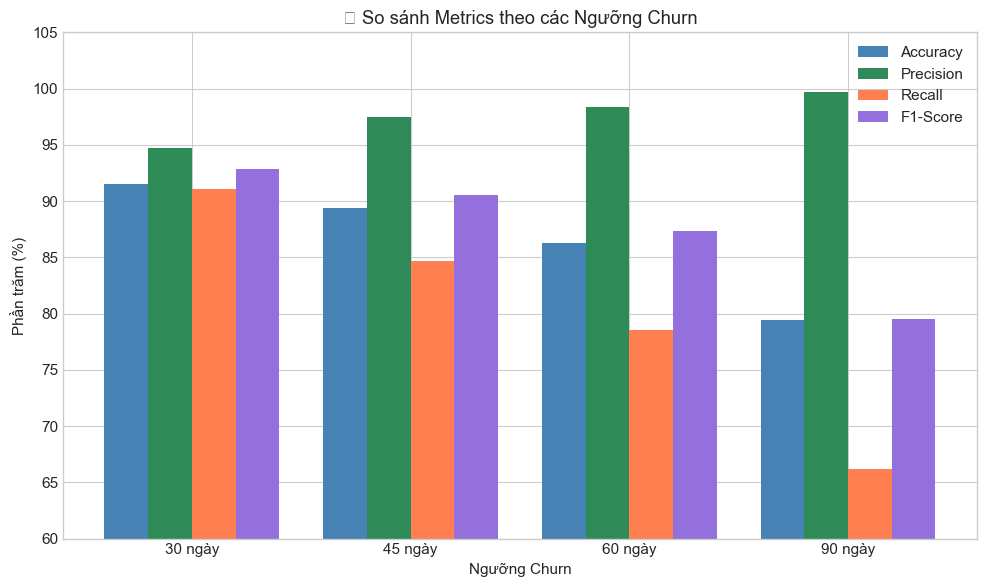


✅ KHUYẾN NGHỊ: Ngưỡng 30 ngày cho F1-Score cao nhất (92.86%) và cân bằng giữa Precision/Recall


In [12]:
# Visualize so sánh metrics
metrics_data = {
    'Ngưỡng': ['30 ngày', '45 ngày', '60 ngày', '90 ngày'],
    'Accuracy': [91.53, 89.35, 86.24, 79.43],
    'Precision': [94.71, 97.43, 98.35, 99.74],
    'Recall': [91.09, 84.63, 78.57, 66.17],
    'F1-Score': [92.86, 90.58, 87.36, 79.56]
}
metrics_df = pd.DataFrame(metrics_data)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metrics_df['Ngưỡng']))
width = 0.2

bars1 = ax.bar(x - 1.5*width, metrics_df['Accuracy'], width, label='Accuracy', color='steelblue')
bars2 = ax.bar(x - 0.5*width, metrics_df['Precision'], width, label='Precision', color='seagreen')
bars3 = ax.bar(x + 0.5*width, metrics_df['Recall'], width, label='Recall', color='coral')
bars4 = ax.bar(x + 1.5*width, metrics_df['F1-Score'], width, label='F1-Score', color='mediumpurple')

ax.set_xlabel('Ngưỡng Churn')
ax.set_ylabel('Phần trăm (%)')
ax.set_title('📊 So sánh Metrics theo các Ngưỡng Churn')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Ngưỡng'])
ax.legend()
ax.set_ylim(60, 105)

plt.tight_layout()
plt.show()

print("\n✅ KHUYẾN NGHỊ: Ngưỡng 30 ngày cho F1-Score cao nhất (92.86%) và cân bằng giữa Precision/Recall")

### 📝 Nhận xét về ngưỡng churn:

| Ngưỡng | Accuracy | Precision | Recall | F1-Score | Đánh giá |
|--------|----------|-----------|--------|----------|----------|
| 30 ngày | 91.53% | 94.71% | 91.09% | **92.86%** | ⭐ Cân bằng tốt nhất |
| 45 ngày | 89.35% | 97.43% | 84.63% | 90.58% | Precision cao nhưng bỏ lỡ nhiều churn |
| 60 ngày | 86.24% | 98.35% | 78.57% | 87.36% | Quá bảo thủ |
| 90 ngày | 79.43% | 99.74% | 66.17% | 79.56% | Bỏ lỡ 1/3 churned customers |

**Kết luận:** Ngưỡng **30 ngày** là lựa chọn tối ưu với:
- F1-Score cao nhất (92.86%)
- Cân bằng giữa Precision (94.71%) và Recall (91.09%)
- Phù hợp với hành vi giao dịch (97.3% giao dịch trong 30 ngày)

---

## 6. Định Nghĩa Churn Chính Thức và Tạo Label

### 6.1 Áp dụng định nghĩa churn với ngưỡng 30 ngày

In [13]:
# Định nghĩa CHURN chính thức
CHURN_THRESHOLD = 30  # ngày

# Tạo churn label
rfm['churn'] = (rfm['recency'] > CHURN_THRESHOLD).astype(int)

# Tạo bảng dữ liệu cuối cùng với tất cả features
final_customer_data = rfm[['customer_id', 'signup_date', 'last_transaction_date', 
                            'recency', 'frequency', 'total_amount', 'avg_amount',
                            'true_lifetime_days', 'days_active', 'churn']].copy()

print("=" * 70)
print("📋 ĐỊNH NGHĨA CHURN CHÍNH THỨC")
print("=" * 70)
print(f"""
🎯 CHURN DEFINITION:
   Khách hàng được coi là CHURNED (churn = 1) nếu:
   ➡️ Recency > {CHURN_THRESHOLD} ngày
   (Không có giao dịch trong {CHURN_THRESHOLD} ngày gần nhất tính đến {ANALYSIS_DATE.strftime('%Y-%m-%d')})
""")

print("=" * 70)
print("📊 THỐNG KÊ CHURN")
print("=" * 70)
churn_counts = final_customer_data['churn'].value_counts()
print(f"\n✅ Active (churn = 0): {churn_counts[0]:,} khách hàng ({churn_counts[0]/len(final_customer_data)*100:.2f}%)")
print(f"❌ Churned (churn = 1): {churn_counts[1]:,} khách hàng ({churn_counts[1]/len(final_customer_data)*100:.2f}%)")

print("\n" + "=" * 70)
print("📋 MẪU DỮ LIỆU CUỐI CÙNG (10 dòng đầu)")
print("=" * 70)
display(final_customer_data.head(10))

📋 ĐỊNH NGHĨA CHURN CHÍNH THỨC

🎯 CHURN DEFINITION:
   Khách hàng được coi là CHURNED (churn = 1) nếu:
   ➡️ Recency > 30 ngày
   (Không có giao dịch trong 30 ngày gần nhất tính đến 2025-12-31)

📊 THỐNG KÊ CHURN

✅ Active (churn = 0): 1,209 khách hàng (41.80%)
❌ Churned (churn = 1): 1,683 khách hàng (58.20%)

📋 MẪU DỮ LIỆU CUỐI CÙNG (10 dòng đầu)


,customer_id,signup_date,last_transaction_date,recency,frequency,total_amount,avg_amount,true_lifetime_days,days_active,churn
0,C00000,2025-08-22,2025-12-31,0,12,1222.85,101.904167,204,131,0
1,C00001,2025-03-07,2025-12-20,11,19,1228.46,64.655789,365,288,0
2,C00002,2025-08-18,2025-09-26,96,11,910.64,82.785455,48,39,1
3,C00003,2025-09-22,2025-11-18,43,4,114.71,28.677500,84,57,1
4,C00004,2025-05-28,2025-09-14,108,19,2018.94,106.260000,113,109,1
5,C00005,2025-11-12,2025-12-29,2,8,209.12,26.140000,120,47,0
6,C00006,2025-08-22,2025-11-25,36,3,85.95,28.650000,117,95,1
7,C00007,2025-08-03,2025-09-30,92,5,584.63,116.926000,321,58,1
8,C00008,2025-05-02,2025-10-31,61,14,768.16,54.868571,209,182,1
9,C00009,2025-01-06,2025-06-19,195,18,1697.28,94.293333,172,164,1


### 6.2 Phân tích đặc điểm nhóm Churned vs Active

📊 SO SÁNH ĐẶC ĐIỂM ACTIVE vs CHURNED


,Active (0),Churned (1)
recency_mean,7.06,144.78
recency_median,4.00,134.00
frequency_mean,23.44,10.91
frequency_median,18.00,7.00
total_amount_mean,1377.46,627.33
total_amount_median,909.04,347.84
avg_amount_mean,59.32,58.90
avg_amount_median,53.84,49.83
true_lifetime_days_mean,218.73,117.85
true_lifetime_days_median,214.00,104.00


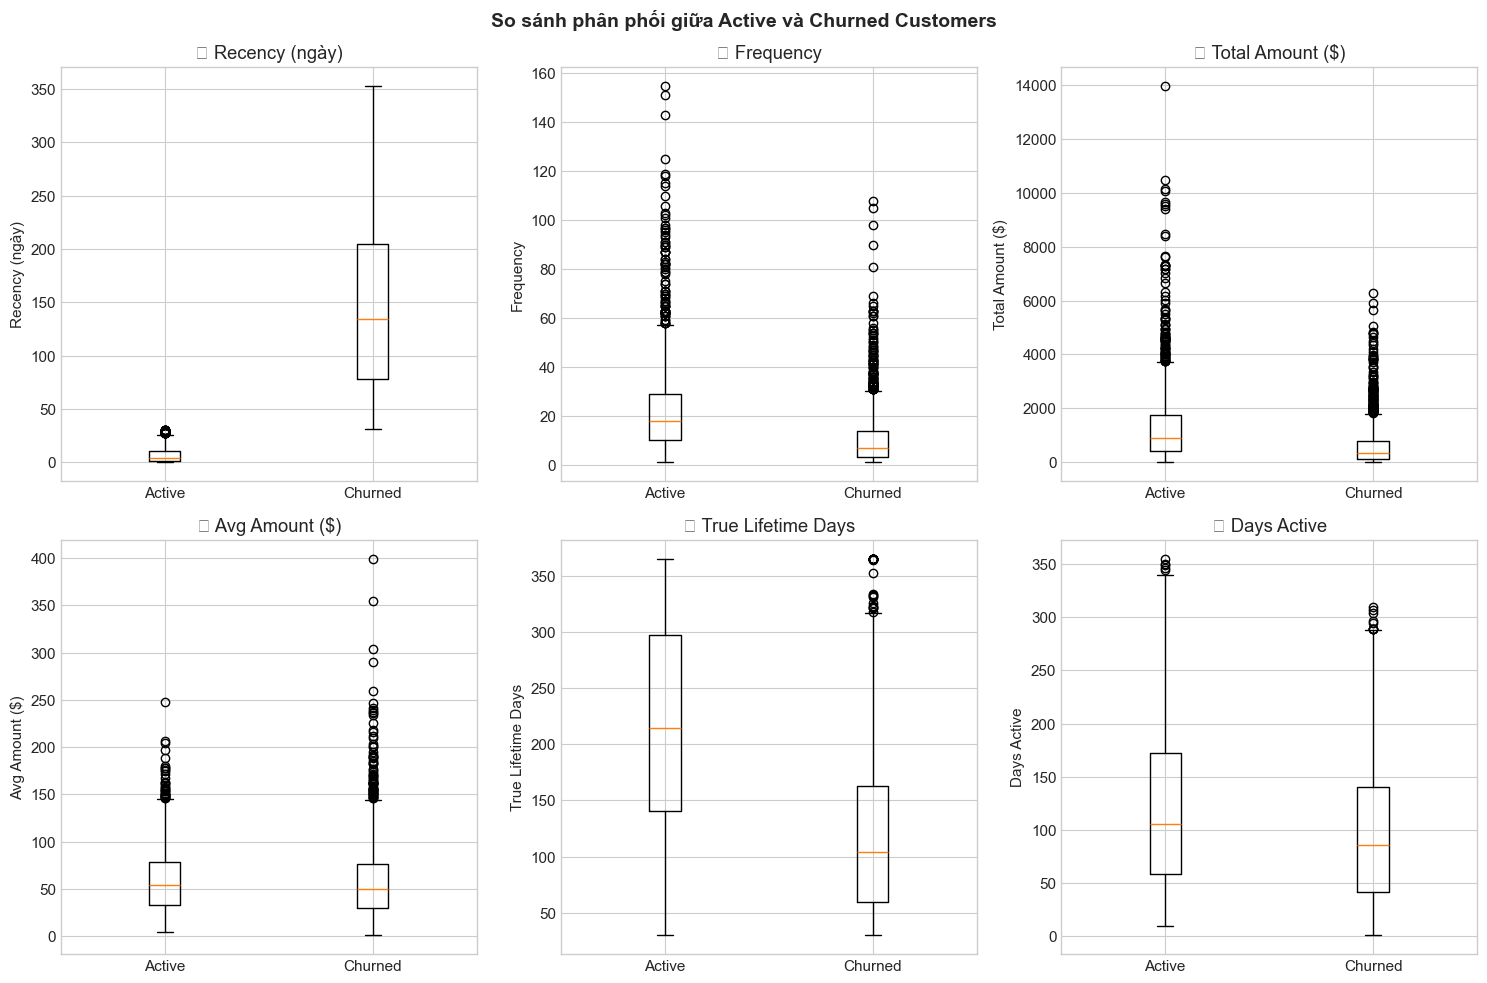

In [14]:
# So sánh đặc điểm giữa nhóm Active và Churned
print("=" * 70)
print("📊 SO SÁNH ĐẶC ĐIỂM ACTIVE vs CHURNED")
print("=" * 70)

comparison = final_customer_data.groupby('churn').agg({
    'recency': ['mean', 'median'],
    'frequency': ['mean', 'median'],
    'total_amount': ['mean', 'median'],
    'avg_amount': ['mean', 'median'],
    'true_lifetime_days': ['mean', 'median'],
    'days_active': ['mean', 'median']
}).round(2)

comparison.columns = ['_'.join(col) for col in comparison.columns]
comparison.index = ['Active (0)', 'Churned (1)']
display(comparison.T)

# Visualize so sánh
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

metrics = ['recency', 'frequency', 'total_amount', 'avg_amount', 'true_lifetime_days', 'days_active']
titles = ['Recency (ngày)', 'Frequency', 'Total Amount ($)', 'Avg Amount ($)', 'True Lifetime Days', 'Days Active']
colors = {'Active': 'steelblue', 'Churned': 'coral'}

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 3, idx % 3]
    
    active_data = final_customer_data[final_customer_data['churn'] == 0][metric]
    churned_data = final_customer_data[final_customer_data['churn'] == 1][metric]
    
    ax.boxplot([active_data, churned_data], labels=['Active', 'Churned'])
    ax.set_title(f'📊 {title}')
    ax.set_ylabel(title)

plt.suptitle('So sánh phân phối giữa Active và Churned Customers', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 📝 Insight quan trọng về Active vs Churned:

| Metric | Active | Churned | Chênh lệch |
|--------|--------|---------|------------|
| Recency (median) | 4 ngày | 134 ngày | **30x** |
| Frequency (median) | 18 giao dịch | 7 giao dịch | **2.6x** |
| Total Amount (median) | $909 | $348 | **2.6x** |
| True Lifetime (median) | 214 ngày | 104 ngày | **2x** |

**Kết luận:**
- Khách hàng **Active** có tần suất giao dịch cao hơn 2.6 lần
- Khách hàng **Active** chi tiêu nhiều hơn 2.6 lần  
- Giá trị trung bình mỗi giao dịch tương đương → Sự khác biệt nằm ở **tần suất**, không phải giá trị đơn lẻ

---

## 7. Lưu Dữ Liệu Đã Xử Lý

In [15]:
# Lưu dữ liệu đã xử lý
output_path = '../customers_with_churn.csv'
final_customer_data.to_csv(output_path, index=False)

print(f"✅ Đã lưu dữ liệu vào: {output_path}")
print(f"📊 Số lượng records: {len(final_customer_data):,}")
print(f"📋 Các cột: {list(final_customer_data.columns)}")

✅ Đã lưu dữ liệu vào: ../customers_with_churn.csv
📊 Số lượng records: 2,892
📋 Các cột: ['customer_id', 'signup_date', 'last_transaction_date', 'recency', 'frequency', 'total_amount', 'avg_amount', 'true_lifetime_days', 'days_active', 'churn']


---

## 8. Tóm Tắt Kết Quả và Khuyến Nghị Cho Stakeholder

### 📊 Tóm tắt phân tích:

**1. Định nghĩa Churn được đề xuất:**
> **Churn = 1** nếu khách hàng **không có giao dịch trong 30 ngày** gần nhất

**2. Căn cứ khoa học:**
- 97.3% giao dịch xảy ra trong vòng 30 ngày sau giao dịch trước
- Ngưỡng 30 ngày đạt F1-Score cao nhất (92.86%) khi so với true lifetime
- Cân bằng tốt giữa Precision (94.71%) và Recall (91.09%)

**3. Kết quả áp dụng:**
- **Active**: 1,209 khách hàng (41.8%)
- **Churned**: 1,683 khách hàng (58.2%)

### 🎯 Khuyến nghị cho Stakeholder:

| Hành động | Mục tiêu | Ưu tiên |
|-----------|----------|---------|
| Chiến dịch re-engagement | Khách hàng 20-30 ngày không giao dịch | 🔴 Cao |
| Loyalty program | Khách hàng Active với frequency cao | 🟡 Trung bình |
| Phân tích nguyên nhân churn | Khách hàng mới churned (31-60 ngày) | 🔴 Cao |
| Upselling | Khách hàng Active với avg_amount thấp | 🟢 Thấp |

### 📈 Bước tiếp theo:
1. **RFM Segmentation**: Phân nhóm khách hàng dựa trên R, F, M scores
2. **CLV Prediction**: Dự đoán giá trị vòng đời khách hàng
3. **Churn Prediction Model**: Xây dựng mô hình ML dự đoán churn sớm
4. **A/B Testing**: Thử nghiệm các chiến dịch retention

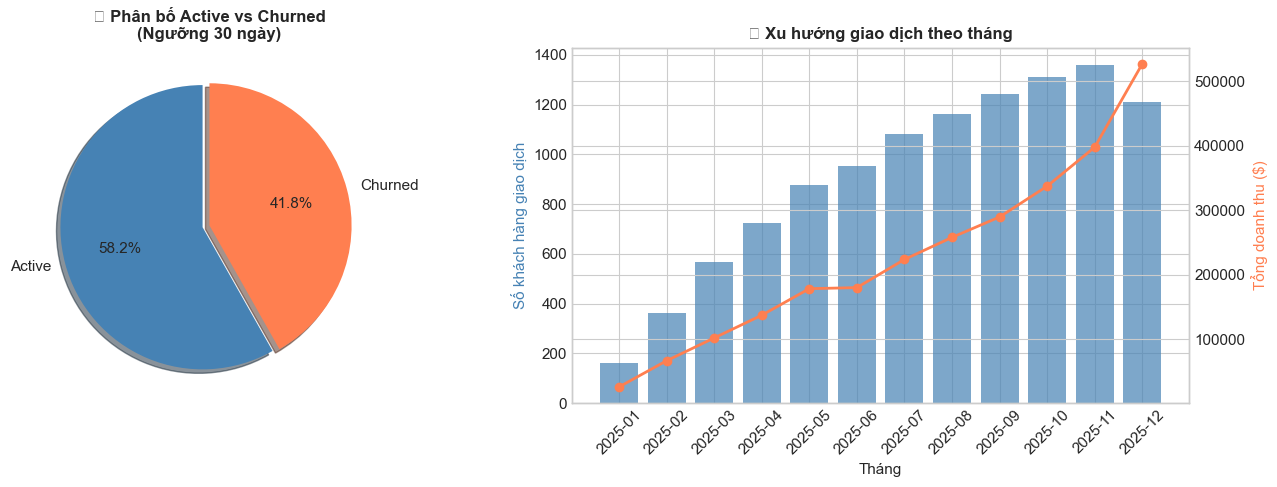


🎉 PHÂN TÍCH HOÀN TẤT!


In [16]:
# Final summary visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Pie chart phân bố churn
ax1 = axes[0]
churn_counts = final_customer_data['churn'].value_counts()
colors = ['steelblue', 'coral']
explode = (0.05, 0)
ax1.pie(churn_counts, labels=['Active', 'Churned'], autopct='%1.1f%%', 
        colors=colors, explode=explode, shadow=True, startangle=90)
ax1.set_title('📊 Phân bố Active vs Churned\n(Ngưỡng 30 ngày)', fontsize=12, fontweight='bold')

# 2. Timeline của giao dịch theo tháng
ax2 = axes[1]
transactions['month'] = transactions['transaction_date'].dt.to_period('M')
monthly_transactions = transactions.groupby('month').agg({
    'customer_id': 'nunique',
    'amount': 'sum'
}).reset_index()
monthly_transactions['month'] = monthly_transactions['month'].astype(str)

ax2_twin = ax2.twinx()
ax2.bar(monthly_transactions['month'], monthly_transactions['customer_id'], 
        color='steelblue', alpha=0.7, label='Số KH giao dịch')
ax2_twin.plot(monthly_transactions['month'], monthly_transactions['amount'], 
              color='coral', marker='o', linewidth=2, label='Tổng doanh thu')

ax2.set_xlabel('Tháng')
ax2.set_ylabel('Số khách hàng giao dịch', color='steelblue')
ax2_twin.set_ylabel('Tổng doanh thu ($)', color='coral')
ax2.set_title('📈 Xu hướng giao dịch theo tháng', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("🎉 PHÂN TÍCH HOÀN TẤT!")
print("=" * 70)